In [1]:
import sys, os
sys.path.append(os.pardir)

In [16]:
from pathlib import Path
import numpy as np
import polars as pl
import os
from hydra import initialize, compose

with initialize(config_path="../run/conf", version_base=None):
    cfg = compose("cv_score", overrides=["exp_name=exp013"])

In [3]:
# series の読み込み
train_df = pl.read_parquet(Path(cfg.dir.data_dir) / "train_series.parquet")
train_df = train_df.with_columns(
            pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%z")
        )
event_df = pl.read_csv(Path(cfg.dir.data_dir) / "train_events.csv")
event_df = event_df.with_columns(
    pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%z")
)

In [32]:
# 予測結果の読み込み
exp_dir = Path(os.path.join(cfg.base_dir, cfg.exp_name, "cv"))

keys_list = []
preds_list = []
for fold in range(cfg.num_fold):
    preds_list.append(np.load(exp_dir / f"preds_fold{fold}.npy"))
    keys_list.append(np.load(exp_dir / f"keys_fold{fold}.npy"))
preds = np.concatenate(preds_list, axis=0)[:,:,[1,2]]
keys = np.concatenate(keys_list, axis=0)

In [33]:
# valid の各ステップに予測結果を付与
count_df = train_df.get_column("series_id").value_counts()
series2numsteps_dict = dict(count_df.select("series_id","counts").iter_rows())

# 順序を保ったままseries_idを取得
all_series_ids = train_df.get_column("series_id").to_numpy()
_, idx = np.unique(all_series_ids, return_index=True)
unique_series_ids = all_series_ids[np.sort(idx)]

key_series_ids = np.array(list(map(lambda x: x.split("_")[0], keys)))

preds_list = []
for series_id in unique_series_ids:
    series_idx = np.where(key_series_ids == series_id)[0]
    this_series_preds = preds[series_idx].reshape(-1, 2)
    this_series_preds = this_series_preds[:series2numsteps_dict[series_id], :]
    preds_list.append(this_series_preds)

preds_all = np.concatenate(preds_list, axis=0)
preds_all.shape

train_preds_df = train_df.with_columns(
                    pl.Series(name="prediction_onset", values=preds_all[:,0]),
                     pl.Series(name="prediction_wakeup", values=preds_all[:,1])
)

In [34]:
from src.utils.post_process import post_process_for_seg

find_peaks_df = post_process_for_seg(
                keys=keys,
                preds=preds,
                score_th=0.0038536733146294715,
                distance=80,
).to_pandas()

In [35]:
find_peaks_df = find_peaks_df.merge(train_df.select(['series_id', 'step', 'timestamp']).to_pandas(), on =['series_id', 'step'])
find_peaks_df

row_id     series_id    step   event     score  \
0            0  038441c925bb     605  wakeup  0.017014   
1            1  038441c925bb    2978   onset  0.057312   
2            2  038441c925bb    3240   onset  0.037415   
3            3  038441c925bb    3325   onset  0.004025   
4            4  038441c925bb    3466   onset  0.005375   
...        ...           ...     ...     ...       ...   
272639  273464  fe90110788d2  591582   onset  0.838867   
272640  273465  fe90110788d2  591703   onset  0.603516   
272641  273466  fe90110788d2  591880   onset  0.011169   
272642  273467  fe90110788d2  591982   onset  0.007996   
272643  273468  fe90110788d2  592139   onset  0.005665   

                       timestamp  
0      2018-08-14 20:20:25+00:00  
1      2018-08-14 23:38:10+00:00  
2      2018-08-15 00:00:00+00:00  
3      2018-08-15 00:07:05+00:00  
4      2018-08-15 00:18:50+00:00  
...                          ...  
272639 2017-09-08 03:08:30+00:00  
272640 2017-09-08 03:18:35+00:00  
272641 2017-09-08 03:33:20+00:00  
272642 2017-09-08 03:41:50+00:00  
272643 2017-09-08 03:54:55+00:00  

[272644 rows x 6 columns]

In [36]:
from src.utils.metrics import event_detection_ap

score = event_detection_ap(
    event_df.drop_nulls().to_pandas(),
    find_peaks_df,
)
score

0.740073539029461

## plot

In [21]:
series_id = event_df.to_pandas()['series_id'].unique()[0]

In [22]:
train_events = event_df.drop_nulls().to_pandas()

35
fe90110788d2 6 2017-08-10 2017-08-10


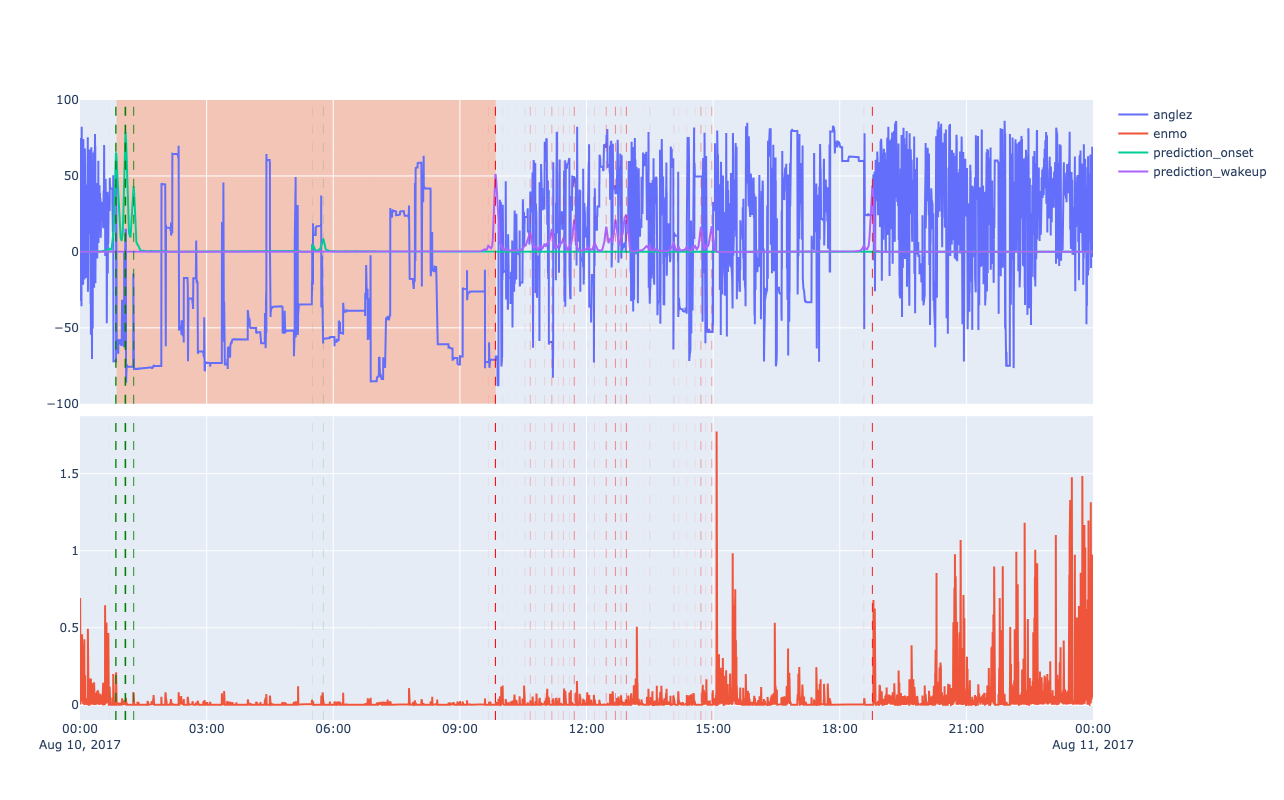

In [74]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

ANGLEZ_MEAN = -8.810476
ANGLEZ_STD = 35.521877
ENMO_MEAN = 0.041315
ENMO_STD = 0.101829


def plot(series_id, night):
    sample_serie = train_preds_df.filter(pl.col("series_id") == series_id)
    """

    sample_serie = sample_serie.with_columns(
                    (pl.col("anglez") - ANGLEZ_MEAN) / ANGLEZ_STD,
                    (pl.col("enmo") - ENMO_MEAN) / ENMO_STD,
                                            )
    """
    fig = make_subplots(rows=2,
                        cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.02)
    fig.update_layout(height=800)
    

    tmp_events = train_events.loc[(train_events['series_id']==series_id)]
    night_events = tmp_events.loc[(tmp_events['night']==night)].reset_index(drop=True)
    
    print(tmp_events['night'].max())
    start_date = night_events["timestamp"].dt.date.min()
    end_date = night_events["timestamp"].dt.date.max()

    night_series = sample_serie.filter((pl.col('timestamp').dt.date() >= start_date).and_(pl.col('timestamp').dt.date() <= end_date)).to_pandas()
    # enmo anglez
    fig.add_trace(go.Scatter(x=night_series['timestamp'], y=night_series['anglez'], mode='lines',name='anglez'), row=1, col=1)
    fig.add_trace(go.Scatter(x=night_series['timestamp'], y=night_series['enmo'], mode='lines',name='enmo'), row=2, col=1)
    # GT
    fig.add_shape(type="rect",
                  x0=night_events["timestamp"][0],
                  x1=night_events["timestamp"][1],
                  y0=-100,  # Set this to a large negative number
                  y1=100,   # Set this to a large positive number
                  fillcolor="LightSalmon",
                  opacity=0.5,
                  layer="below",
                  line_width=0,
                  row=1, col=1
                  )
    # prob
    fig.add_trace(go.Scatter(x=night_series['timestamp'], y=night_series['prediction_onset']*100, mode='lines',name='prediction_onset'), row=1, col=1)
    fig.add_trace(go.Scatter(x=night_series['timestamp'], y=night_series['prediction_wakeup']*100, mode='lines',name='prediction_wakeup'), row=1, col=1)

    print(series_id, night, start_date, end_date)
    
    """
    for i, event_row in night_events.iterrows():
        color = 'gray'
        fig.add_vline(x=event_row['timestamp'], line_color=color,  row=1, col=1)
        fig.add_vline(x=event_row['timestamp'], line_color=color,  row=2, col=1)
    """

    # peak
    peaks_df = pl.from_pandas(find_peaks_df[find_peaks_df['series_id']==series_id]).filter((pl.col('timestamp').dt.date() >= start_date).and_(pl.col('timestamp').dt.date() <= end_date)).to_pandas()
    for _, pred_row in peaks_df.iterrows():
        color = 'green' if pred_row["event"]=='onset' else 'red'
        fig.add_vline(x=pred_row['timestamp'],line_width=pred_row['score']*2, line_color=color, line_dash="dash",
                  layer="above", row=1, col=1) #  
        fig.add_vline(x=pred_row['timestamp'],line_width=pred_row['score']*2, line_color=color, line_dash="dash",
                  layer="above", row=2, col=1)

    
    fig.show()


series_id = "fe90110788d2"
night = 6
plot(series_id, night)